# LIB IMPORT

In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPool2D, Activationi, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# CREATE IMBALANCED DATASET AND FOR THE 0-1 VALUES IF 

In [67]:


df = pd.read_csv("One_year_compiled.csv")
df =df.drop(['timestamp', 'sample_Number', 'hour', 'day', 'month'], axis = 1)

for i, group in df.groupby(np.arange(len(df)) // 1000000):
    group.to_csv(f"group_{i}.csv", index=False)

df2 = pd.read_csv("group_0.csv")

model = IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2),max_features=1.0)
# contamination Verilerde bulunması beklenen aykırı değerlerin veya anormalliklerin oranını tanımlar.
model.fit(df2[["pCut::Motor_Torque"]])
df2['torq_anomalies_score'] = model.decision_function(df2[["pCut::Motor_Torque"]])
df2['torq_anomaly'] = model.predict(df2[["pCut::Motor_Torque"]])

df_main = df2[['pCut::CTRL_Position_controller::Actual_position']].copy()

df_main['pSvolFilm::CTRL_Position_controller::Actual_position'] = df2['pSvolFilm::CTRL_Position_controller::Actual_position']

df_main['torq_anomaly'] = df2['torq_anomaly']

df_main.replace(-1, 0, inplace=True)

df_torq = df2[['torq_anomaly']].copy()

df_torq.replace(-1, 0, inplace=True)

# oversampling opencv kullan 
# görsele zoom at
# 100000 veri yap


/Users/erdemsevinc/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


# NORMALIZATION

In [68]:
scaler = StandardScaler()

# Veriyi normalize etme
normalize_edilmis_veri = scaler.fit_transform(df_main)

# TRAIN TEST SPLIT

In [69]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(normalize_edilmis_veri, df_torq, test_size=0.2, random_state=42)


# SMOTE OVERSAMPLING

In [70]:
#smt = SMOTE()

#X_test_sm, y_test_sm = smt.fit_resample(X_test, y_test)


# TRAIN OC SVM MODEL

In [71]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

# PREDICT ANOMALIES

In [72]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
# Change the anomalies' values to make it consistent with the true values
prediction = [0 if i==-1 else 1 for i in prediction]
# Check the model performance
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.54      0.03      0.05     40202
           1       0.80      0.99      0.89    159798

    accuracy                           0.80    200000
   macro avg       0.67      0.51      0.47    200000
weighted avg       0.75      0.80      0.72    200000



# IOU SCORE

In [73]:
def calculate_iou(y_train, y_test):
    intersection = np.logical_and(y_train, y_test)
    union = np.logical_or(y_train, y_test)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score



iou = calculate_iou(y_train, y_test)
print("IoU Score:", iou)

IoU Score: torq_anomaly    0.800059
dtype: float64


# CUSTOMIZE PREDICTIONS USING SCORE

In [74]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 7)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(y_test, customized_prediction))
#paperswithcode

The customized score threshold for 2% of outliers is 988.14
              precision    recall  f1-score   support

           0       0.20      0.92      0.33     40202
           1       0.77      0.07      0.12    159798

    accuracy                           0.24    200000
   macro avg       0.49      0.49      0.23    200000
weighted avg       0.66      0.24      0.17    200000



# VISUALIZATION

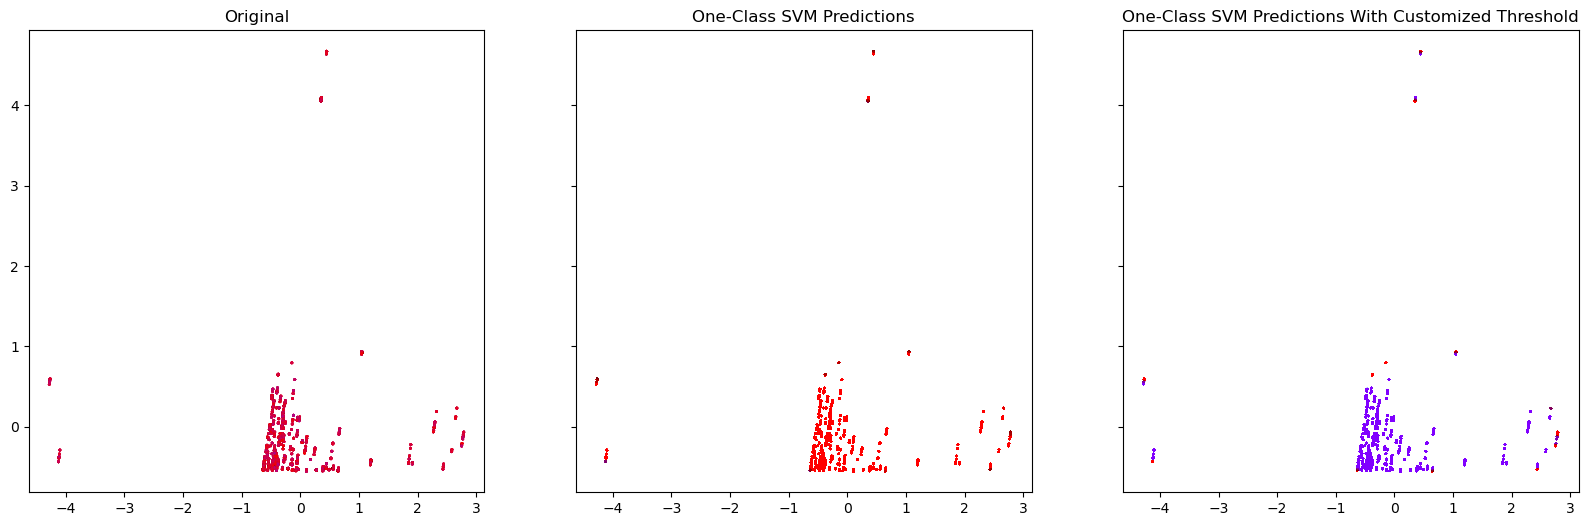

In [75]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['pCut::CTRL_Position_controller::Actual_position', 'pSvolFilm::CTRL_Position_controller::Actual_position','torq_anomaly'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction


fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 6))

ax0.set_title('Original')
ax0.scatter(df_test['pCut::CTRL_Position_controller::Actual_position'], df_test['pSvolFilm::CTRL_Position_controller::Actual_position'], c=df_test['y_test'], cmap='rainbow', alpha=0.1, s=1)

# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['pCut::CTRL_Position_controller::Actual_position'], df_test['pSvolFilm::CTRL_Position_controller::Actual_position'], c=df_test['one_class_svm_prediction'], cmap='rainbow', alpha=0.01, s=1)

# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['pCut::CTRL_Position_controller::Actual_position'], df_test['pSvolFilm::CTRL_Position_controller::Actual_position'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow', alpha=0.01, s=1)


